In [ ]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics

# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_sarimax import (
    prepare_sarimax_data,
    check_stationarity,
    plot_acf_pacf,
    fit_sarimax_model,
    analyze_residual_spike,
    ljung_box_test,
    forecast_sarimax_model,
    identify_peak_hours_sarimax,
    evaluate_sarimax_metrics,
    rolling_forecast_sarimax,
    generate_future_forecast_sarimax,
    group_forecast_by_hour,
    
)

from models.model_sarimax import (
    sarimax_grid_search,
    retrain_sarimax_model,
    ljung_box_test_residuals,
    forecast_with_refined_sarimax,
    analyze_peak_hours_sarimax_refined,
    evaluate_refined_sarimax_metrics,
    rolling_forecast_sarimax_refined,
    forecast_future_sarimax_model_refined,
    future_forecast_by_hour_sarimax_refined
)

 Working directory: /Users/sudishmakarki/My_project2


In [2]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [3]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for SARIMAX
train_series, test_series = prepare_sarimax_data(restaurant_train, restaurant_test)

Baseline Model for SARIMAX

ADF Statistic: -15.026219911968534
p-value: 1.00551216199881e-27
Result: Stationary


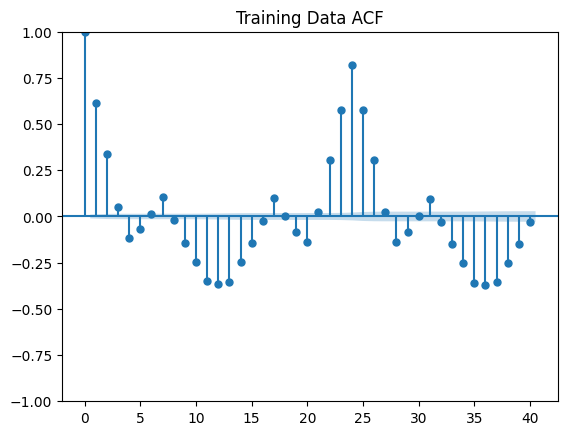

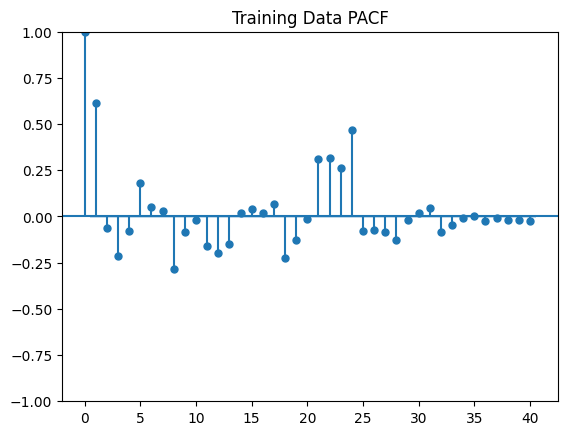

In [4]:
# --- Stationarity Check & ACF/PACF ---
check_stationarity(train_series)
plot_acf_pacf(train_series, lags=40, title_prefix="Training Data")

In [5]:
# --- Fit SARIMAX Baseline Model ---
results_sarimax = fit_sarimax_model(train_series)

                                     SARIMAX Results                                      
Dep. Variable:                      CustomerCount   No. Observations:                35064
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -114396.022
Date:                            Thu, 10 Apr 2025   AIC                         228802.044
Time:                                    15:28:56   BIC                         228844.365
Sample:                                01-01-2018   HQIC                        228815.524
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1368      0.005     25.681      0.000       0.126       0.147
ma.L1         -0.9423      0.002   

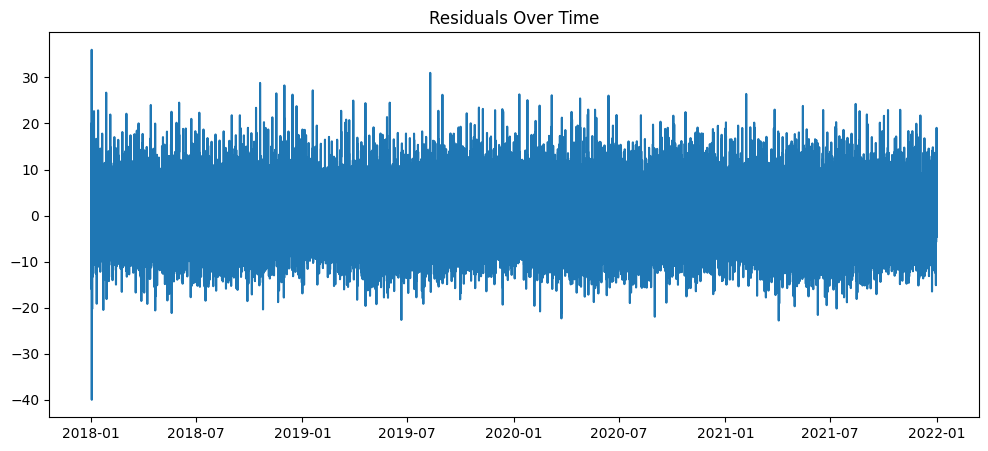

In [6]:
# -- Residual Analysis ---
residuals = results_sarimax.resid

# Residual plot + ACF/PACF
plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

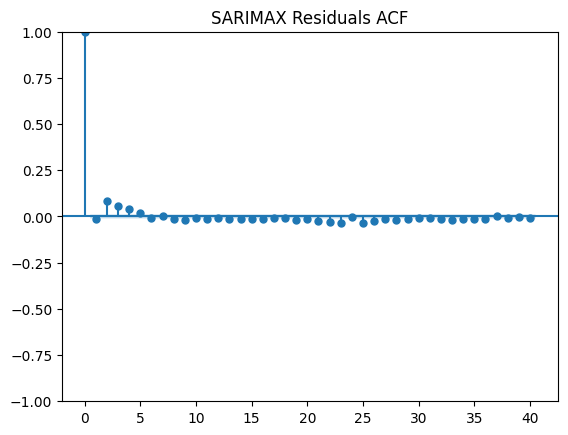

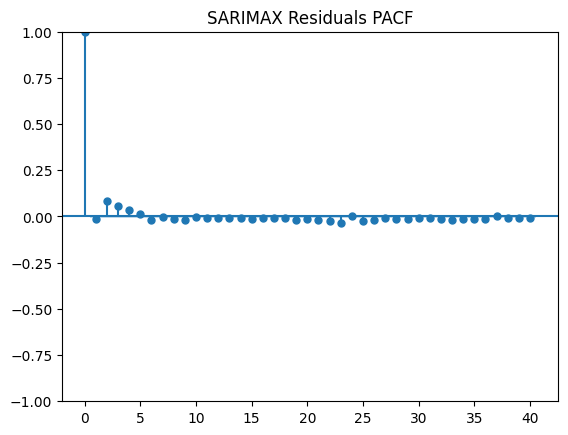

In [7]:
plot_acf_pacf(residuals, lags=40, title_prefix="SARIMAX Residuals")


In [8]:
# Residual spike + Ljung-Box
analyze_residual_spike(residuals, train_series.to_frame(name="CustomerCount/n"))
ljung_box_test(residuals)

Largest residual at: 2018-01-01 22:00:00
Residual value: -39.99965833176916

Data at the timestamp with the largest residual:
CustomerCount/n    9
Name: 2018-01-01 22:00:00, dtype: int64
Ljung-Box test results:
       lb_stat     lb_pvalue
10  436.673183  1.451813e-87


,lb_stat,lb_pvalue
10,436.673183,1.451813e-87


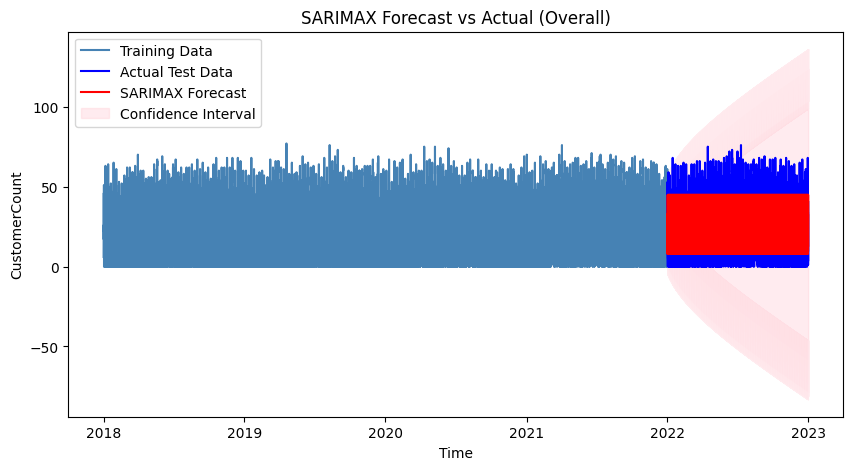

In [9]:
# --- Forecast on Test Set ---
forecast_mean, forecast_ci = forecast_sarimax_model(results_sarimax, len(test_series), test_index=test_series.index)
forecast_mean.head()
forecast_ci.head()

# --- Overall Forecast vs Actual --
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Overall)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.show()

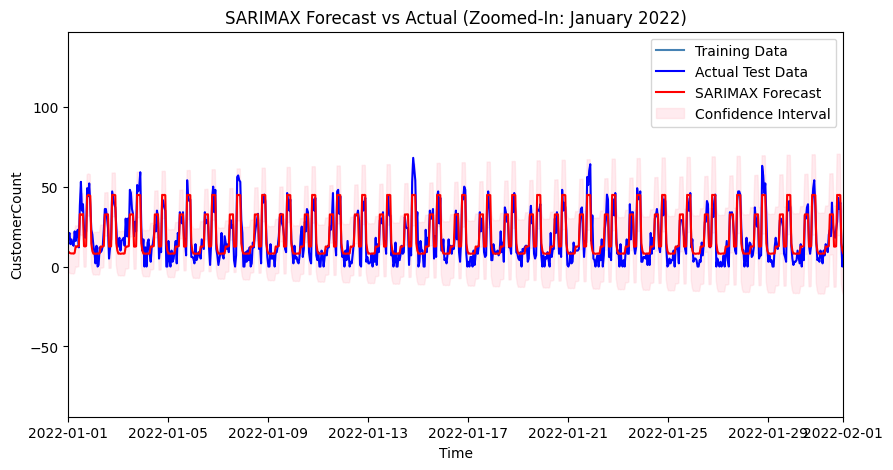

In [10]:
# --- Zoomed-In View: First Month of 2022 ---
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Zoomed-In: January 2022)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-02-01"))
plt.legend()
plt.show()

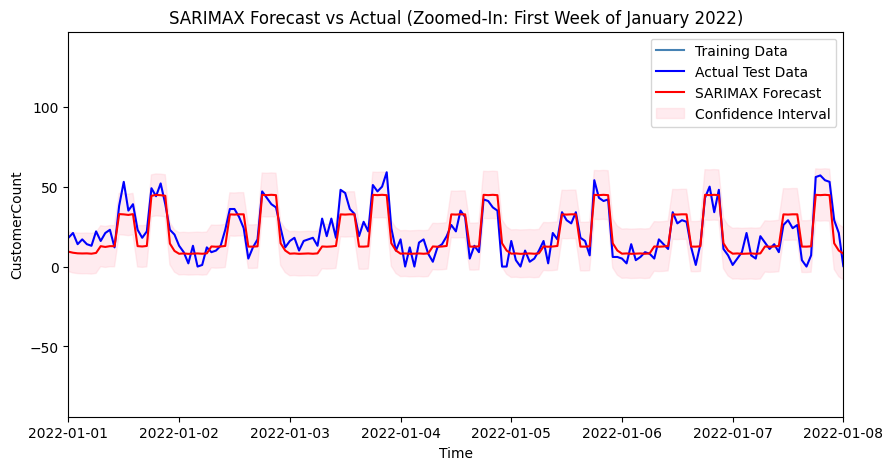

In [11]:
# --- Zoomed-In View: First Week of January 2022 ---
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Zoomed-In: First Week of January 2022)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-01-08"))
plt.legend()
plt.show()

In [12]:
# ---Peak Hour Detection ---
peak_hours, threshold, hourly_avg, forecast_peak, test_peak = identify_peak_hours_sarimax(forecast_mean, test_series)

# Display threshold and peak hours
print(f" Threshold for Peak Hours: {threshold:.2f}")
print(f" Dynamically Identified Peak Hours: {peak_hours}")

# Convert hourly average to a tidy DataFrame
hourly_avg_df = hourly_avg.reset_index()
hourly_avg_df.columns = ['Hour of Day', 'Average Forecasted Customers']
hourly_avg_df['Average Forecasted Customers'] = hourly_avg_df['Average Forecasted Customers'].round(2)

# View hourly average
# Heatmap-style table for hourly averages
display(
    hourly_avg_df
    .style
    .hide(axis="index")  # hide the default index column
    .set_caption("Hourly Average Forecast - SARIMAX")
    .background_gradient(cmap='YlOrRd')  # warm colors for peak intensity
)

# Show preview of peak hour filtered data
print("\nForecasted Data (Peak Hours):")
display(forecast_peak.head())

print("\nActual Data (Peak Hours):")
display(test_peak.head())

 Threshold for Peak Hours: 26.92
 Dynamically Identified Peak Hours: [11, 12, 13, 14, 18, 19, 20, 21]


Hour of Day,Average Forecasted Customers
0,8.060000
1,8.210000
2,7.960000
3,8.070000
4,8.200000
5,8.010000
6,8.250000
7,12.570000
8,12.400000
9,12.560000



Forecasted Data (Peak Hours):


,yhat,Hour
Timestamp,,
2022-01-01 11:00:00,32.815467,11
2022-01-01 12:00:00,32.640529,12
2022-01-01 13:00:00,32.293618,13
2022-01-01 14:00:00,32.796972,14
2022-01-01 18:00:00,44.251358,18



Actual Data (Peak Hours):


,y,Hour
Timestamp,,
2022-01-01 11:00:00,38,11
2022-01-01 12:00:00,53,12
2022-01-01 13:00:00,35,13
2022-01-01 14:00:00,39,14
2022-01-01 18:00:00,49,18


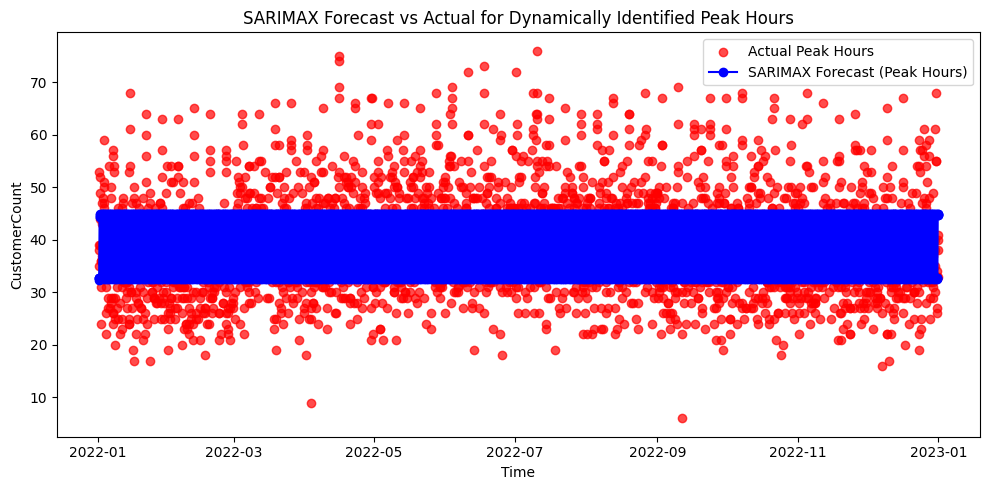

In [13]:
# Plot forecast vs actual for peak hours
plt.figure(figsize=(10, 5))
plt.scatter(test_peak.index, test_peak['y'], color='red', label='Actual Peak Hours', alpha=0.7)
plt.plot(forecast_peak.index, forecast_peak['yhat'], marker='o', linestyle='-', color='blue', label='SARIMAX Forecast (Peak Hours)')
plt.title("SARIMAX Forecast vs Actual for Dynamically Identified Peak Hours")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# --- 7. Evaluate Metrics (Overall & Peak) ---
metrics = evaluate_sarimax_metrics(test_series, forecast_mean, test_peak, forecast_peak)

print("\nOverall Metrics:")
for k, v in metrics["overall"].items():
    print(f"{k}: {v:.2f}")

print("\nPeak Hours Metrics:")
for k, v in metrics["peak_hours metrics"].items():
    print(f"{k}: {v:.2f}")



Overall Metrics:
MAE: 5.65
RMSE: 7.18
MAPE: 1734294755845862.00

Peak Hours Metrics:
MAE: 5.98
RMSE: 7.75
MAPE: 0.16


In [ ]:
# --- Rolling Forecast Evaluation ---
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

rolling_overall, rolling_peak, *_ = rolling_forecast_sarimax(
    train_series,
    test_series,
    order=order,
    seasonal_order=seasonal_order,
    peak_hours_dynamic=peak_hours,
    window_size=500,
    step=5,
    forecast_steps=1,
    max_points=50
)

print("\nRolling Forecast (Overall):", rolling_overall)
print("\nRolling Forecast (Peak Hours):", rolling_peak)


Rolling Forecast (Overall): {'MAE': 20.270701355051322, 'RMSE': np.float64(23.591787137341118), 'MAPE': 1.0514661355063872}

Rolling Forecast (Peak Hours): {'MAE': 35.61420666531899, 'RMSE': np.float64(36.36708935176312), 'MAPE': 0.8508161337361914}


In [16]:
# Generate 30-day ahead forecast using SARIMAX
forecast_future_sarimax = generate_future_forecast_sarimax(results_sarimax, periods=30*24)

# Preview the forecast
forecast_future_sarimax.head()

,yhat,ds,Hour
2022-01-01 00:00:00,9.309387,2022-01-01 00:00:00,0
2022-01-01 01:00:00,8.646189,2022-01-01 01:00:00,1
2022-01-01 02:00:00,8.275653,2022-01-01 02:00:00,2
2022-01-01 03:00:00,8.188410,2022-01-01 03:00:00,3
2022-01-01 04:00:00,8.247348,2022-01-01 04:00:00,4


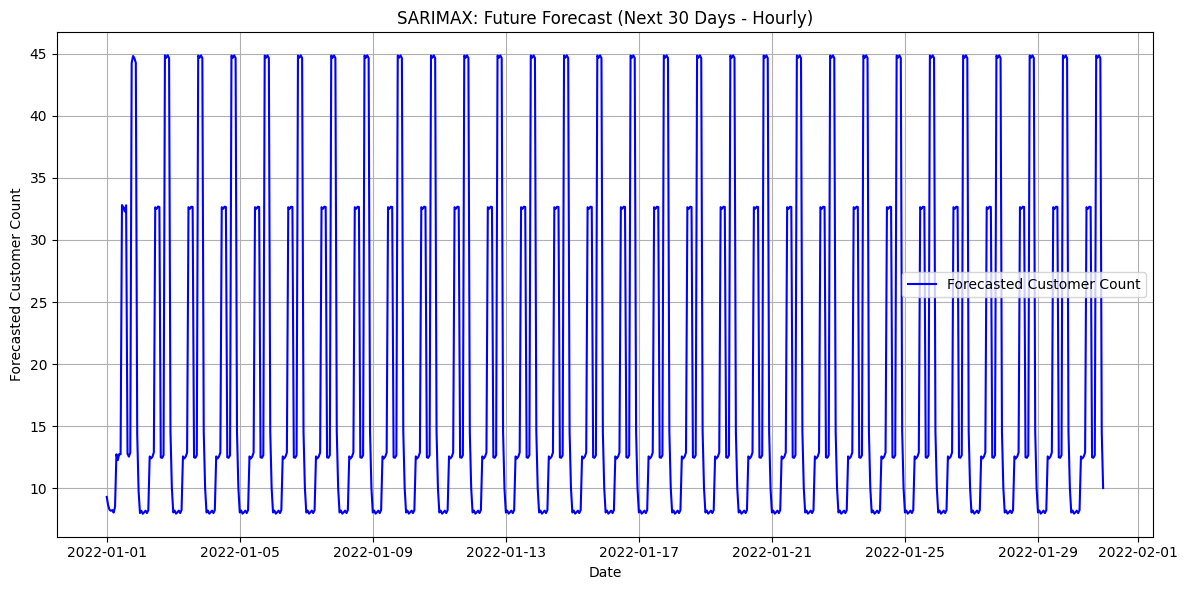

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_future_sarimax['ds'], forecast_future_sarimax['yhat'], color='blue', label='Forecasted Customer Count')
plt.title("SARIMAX: Future Forecast (Next 30 Days - Hourly)")
plt.xlabel("Date")
plt.ylabel("Forecasted Customer Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Group future forecast by hour and find peak hours
hourly_avg_sarimax, threshold_sarimax, future_peak_hours_sarimax = group_forecast_by_hour(
    forecast_future_sarimax, threshold_ratio=0.6
)

# Display the colored hourly forecast table
display(
    hourly_avg_sarimax
    .style
    .set_caption("SARIMAX: 30-Day Future Hourly Avg Forecast")
    .background_gradient(cmap='Blues', axis=0)
    .hide(axis="index")  # Optional: hide index for clean look
)

# Print peak hour info
print(f"\nThreshold for Peak Hours (60% of max): {threshold_sarimax:.2f}")
print(f"Future Peak Hours Identified: {future_peak_hours_sarimax}")

Hour,Avg Forecast (yhat)
0,8.090000
1,8.220000
2,7.970000
3,8.070000
4,8.200000
5,8.010000
6,8.250000
7,12.580000
8,12.400000
9,12.560000



Threshold for Peak Hours (60% of max): 26.92
Future Peak Hours Identified: [11, 12, 13, 14, 18, 19, 20, 21]


SARIMAX Grid search for model refinement 